# Documenting *simulation* workflow using the Ebrains Knowledge Graph 

# --> provenance tracking using fairgraph

In [1]:
%%capture
!rm -rf fairgraph
!git clone https://github.com/yzerlaut/fairgraph.git # TEMPORARY 
!pip install -r ./fairgraph/requirements.txt
!pip install -U ./fairgraph
import os, sys, datetime
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

### A simple demo case: A thresholded Wiener process simulating intracellular dynamics

In [5]:
# The simulation source code are available in a public container at CSCS
container_url = 'https://object.cscs.ch/v1/AUTH_6ebec77683fb472f94d352be92b5a577/fairgraph_demo'
#### SCRIPT ####
if not os.path.isfile('analysis_script.py'):
   os.system('wget %s/analysis_script.py' % container_url)
if not os.path.isfile('simulation_script.py'):
   os.system('wget %s/simulation_script.py' % container_url)

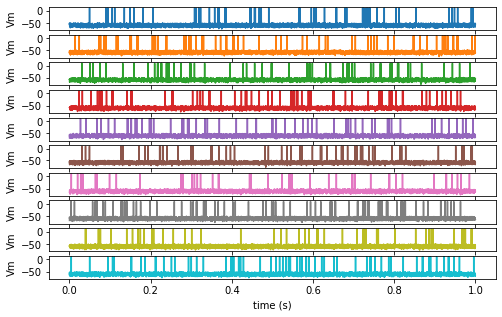

In [41]:
%run simulation_script.py full
# 'full' for: 'run' and 'plot'

## Setting up the client for the interaction with the KG

In [7]:
import os
from fairgraph import KGClient
# needs to have HBP_AUTH_TOKEN set as a bash variable !
# get your token at: https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize
dev = True
if dev:
    client = KGClient(os.environ["HBP_AUTH_TOKEN"],
                      nexus_endpoint='https://nexus-int.humanbrainproject.org/v0')
else:
    client = KGClient(os.environ["HBP_AUTH_TOKEN"])

## Model Metadata

### Simulation code / script

In [15]:
from fairgraph.brainsimulation import ModelScript
from fairgraph.base import Distribution
from datetime import datetime

## --> starting with script metadata underlying the model
simulation_script = ModelScript(name='Script for Toy model#%s of network dynamics for demo purpose' % str(datetime.now),
                                            code_format='python',
                                            distribution=Distribution(container_url+'/simulation_script.py'),
                                           license='CC BY-SA')
simulation_script.save(client) # SAVE IN KG
print('The KG ID is:', simulation_script.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/emodelscript/v0.1.0/27bfed46-cbb0-4a2c-a524-70e34fea32a2


### model description

In [16]:
## --> building a model instance (version) from those metadata
from fairgraph.brainsimulation import ModelInstance
from datetime import datetime
my_model = brainsimulation.ModelInstance(name= 'Toy model#%s of neural network dynamics for demo purpose' % str(datetime.now),
                                         main_script=simulation_script,
                                         description="""
                                         This model#%s implements a very simple description of desynchronized 
                                         activity in neural assemblies:
                                         - Single neuron spiking consists of independent Poisson processes
                                         - Vm fluctuations are sampled from a random process with Gaussian distribution
                                         """  % str(datetime.now) ,
                                         version='v0')

my_model.save(client) # SAVE IN KG
print('The KG ID is:', my_model.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/modelinstance/v0.1.1/14e03c5d-5bc4-43fd-b443-9590c9f50f84


## Simulation parameters

In [58]:
## --> parameters/configuration
from fairgraph.brainsimulation import SimulationConfiguration

Parameters = SimpleNamespace(dt=1e-4, tstop=10., seed=0,
                             mean_Vm=-60., std_Vm=4.,  
                             V_thresh=-46., V_peak=0.,
                             N_pop=1000, N_recVm=100,
                             filename='long_simulation.npz')

import json
with open('simulation_parameters.json', 'w') as f:
    json.dump(dict(vars(Parameters)), f)
    
spike_config = SimulationConfiguration(name='parameter configuration of toy model#%s in demo notebook',
                                       description=''.join(['%s=%s ; ' % kv for kv in dict(vars(Parameters)).items()]),
                                       config_file=Distribution('simulation_parameters.json'))

spike_config.save(client)
print('The KG ID is:', spike_config.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/simulationconfiguration/v0.0.2/e55b0c50-698e-428b-995d-4ee527080eb9


## Performing the simulation

In [59]:
from simulation_script import run_model

# run
data = run_model(Parameters)
# save results
np.savez('Vm_long_simulation', **{'Vm_traces':data['Vm_traces'], 'args':vars(Parameters)})
np.savez('spike_long_simulation', **{'spiketimes':data['spiketimes'], 'spikeIDs':data['spikeIDs'], 'args':vars(Parameters)})

## Simulation results

### for small files, directly stored on the KG

In [61]:
# for small files, we can store them directly on the knowledge graph
spike_result = brainsimulation.SimulationResult(name='spike results of toy model#%s in demo notebook'  % str(datetime.now),
                                                generated_by = my_model,
                                                report_file='spike_long_simulation.npz',
                                                data_type = 'network activity data', 
                                                variable='spike',
                                                target='soma',
                                                parameters = ''.join(['%s=%s ; ' % kv for kv in vars(args).items()]),
                                                description='Spiking data of model run in faigraph-demo notebook')
spike_result.save(client)
print('The KG ID is:', spike_result.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/simulationresult/v0.0.4/2b7dc1c6-7405-4433-86ce-884a40cd4a27


### for big files, need a specific storage (e.g. CSCS) and the url reference uses a Distribution object

In [62]:
# create the distribution:
vm_location = brainsimulation.Distribution('https://object.cscs.ch/v1/AUTH_c0a333ecf7c045809321ce9d9ecdfdea/simulation_result_demo/data/Vm_long_simulation.npz')
# associate to the SimulationResult object:
Vm_result = brainsimulation.SimulationResult(name='Vm results of toy model#%s in demo notebook' % str(datetime.now),
                                             generated_by = my_model,
                                             data_type = 'network simulation data', 
                                             report_file=vm_location, # Now a Distribution !
                                             variable='spike',
                                             target='soma',
                                             parameters = ''.join(['%s=%s ; ' % kv for kv in vars(args).items()]),
                                             description='Intracellular data of model run in faigraph-demo notebook')
# now saving will be succesfull
Vm_result.save(client)
print('The KG ID is:', Vm_result.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/simulationresult/v0.0.4/b123a76f-c0e4-4b6e-991e-bedb7bd1a959


## Performing the analysis

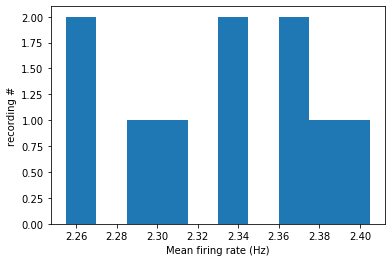

In [7]:
analysis_start_time = datetime.datetime.now()
from analysis_script import calculate_spiking_rate_from_Vm

args = data['args'].item()
t= np.arange(int(args['tstop']/args['dt']))*args['dt']

FiringRates = []
for i, vm in enumerate(data['Vm_traces']):
    fr = calculate_spiking_rate_from_Vm(t, vm,
                                        threshold=Parameters['threshold_for_spike_detection_mV'])
    FiringRates.append(fr)
np.save('mean_firing_rates.npy', FiringRates)

plt.hist(FiringRates)
plt.xlabel('Mean firing rate (Hz)')
plt.ylabel('recording #')
plt.gcf().savefig('mean_firing_rate_histogram.png')

analysis_end_time = datetime.datetime.now();

## Analysis results

In [8]:
from fairgraph.analysis import AnalysisResult

# for small files, we can store them directly on the knowledge graph
analysis_result = AnalysisResult(name='results of firing rate analysis in demo notebook',
                                 report_file='mean_firing_rates.npy',
                                 data_type = 'firing rate', 
                                 variable='spike',
                                 description='results of firing rate analysis in demo notebook')
analysis_result.save(client)
print('The KG ID is:', analysis_result.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/analysisresult/v0.0.1/0b01977c-4142-426f-912a-acdda806f75d


## Full Simulation Activity

In [12]:
from fairgraph.brainsimulation import SimulationActivity, Person

## --> agent
yann = Person(family_name='Zerlaut',
              given_name='Yann',
              email='yann.zerlaut@cnrs.fr')
yann.save(client)
print('The KG ID is:', yann.id)

## --> activity
sim = brainsimulation.SimulationActivity(name='parameter configuration of toy model#%s in demo notebook'  % str(datetime.now),
                                         description='',
                                         configuration_used=spike_config,
                                         simulation_script=sc,
                                         model_instance=my_model,
                                         timestamp=datetime.now(),
                                         result = (spike_result, Vm_result),
                                         started_by = yann,
                                         ended_at_time=datetime.now())

sim.save(client)
print('The KG ID is:', sim.id)

ERROR GET (401): https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/core/person/v0.1.0/?&filter=%7B%22op%22%3A+%22and%22%2C+%22value%22%3A+%5B%7B%22path%22%3A+%22schema%3AfamilyName%22%2C+%22op%22%3A+%22eq%22%2C+%22value%22%3A+%22Zerlaut%22%7D%2C+%7B%22path%22%3A+%22schema%3AgivenName%22%2C+%22op%22%3A+%22eq%22%2C+%22value%22%3A+%22Yann%22%7D%5D%7D&context=%7B%22schema%22%3A+%22http%3A%2F%2Fschema.org%2F%22%2C+%22prov%22%3A+%22http%3A%2F%2Fwww.w3.org%2Fns%2Fprov%23%22%7D&from=0&size=100&deprecated=False&fields=all&deprecated=False null b'{"@context":"https://nexus-int.humanbrainproject.org/v0/contexts/nexus/core/error/v0.1.0","code":"UnauthorizedAccess"}' {"@context":"https://nexus-int.humanbrainproject.org/v0/contexts/nexus/core/error/v0.1.0","code":"UnauthorizedAccess"}
ERROR GET (401): https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/core/person/v0.1.0/?&filter=%7B%22op%22%3A+%22and%22%2C+%22value%22%3A+%5B%7B%22path%22%3A+%22schema%3AfamilyName%22%2C+%22

HTTPError: 401 Client Error: Unauthorized for url: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/core/person/v0.1.0/?&filter=%7B%22op%22%3A+%22and%22%2C+%22value%22%3A+%5B%7B%22path%22%3A+%22schema%3AfamilyName%22%2C+%22op%22%3A+%22eq%22%2C+%22value%22%3A+%22Zerlaut%22%7D%2C+%7B%22path%22%3A+%22schema%3AgivenName%22%2C+%22op%22%3A+%22eq%22%2C+%22value%22%3A+%22Yann%22%7D%5D%7D&context=%7B%22schema%22%3A+%22http%3A%2F%2Fschema.org%2F%22%2C+%22prov%22%3A+%22http%3A%2F%2Fwww.w3.org%2Fns%2Fprov%23%22%7D&from=0&size=100&deprecated=False&fields=all&deprecated=False